# Split Train-Test Data

In [ ]:
! pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 4.9 MB/s 


In [ ]:
# Import needed libraries
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import power_transform
from skmultilearn.problem_transform import LabelPowerset
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

In [ ]:
# Read in the data
imdb = pd.read_csv('imdb-transformed.csv')

# Define all genres
genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama',
          'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
          'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']
genre_cols = ["Genre_" + genre for genre in genres]

# Split data into features and labels and normalize features
X = imdb.copy().drop(columns=genre_cols)
X = (X - X.mean()) / X.std()
X_cols = X.columns
X = power_transform(np.array(X), method='yeo-johnson')
X = pd.DataFrame(X, columns=X_cols)
y = imdb.copy()[genre_cols]

# Drop all genres with less than 100 movies
kept_genres = genre_cols.copy()
for genre_col in genre_cols:
    indices = y[y[genre_col] == 1].index.tolist()
    if len(indices) < 100:
        y = y.drop(columns=[genre_col])
        kept_genres.remove(genre_col)
print(kept_genres)

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save non-oversampled data
X_train_ns = X_train
y_train_ns = y_train

# Apply multilabel to multiclass transformation so we can oversample
lp = LabelPowerset()
y_train_mc = lp.transform(y_train)

# Oversample
ros = RandomOverSampler(random_state=42)
X_train, y_resample = ros.fit_resample(X_train, y_train_mc)

# Get the original multilabelled data
y_resample = lp.inverse_transform(y_resample)
y_train = y_resample.toarray()

['Genre_Action', 'Genre_Adventure', 'Genre_Comedy', 'Genre_Crime', 'Genre_Drama', 'Genre_Romance', 'Genre_Sci-Fi', 'Genre_Thriller']


In [ ]:
# Define a function for scoring the performance of our model
# Useful for cross-validation
def roc_score(estimator, X, y):
    return roc_auc_score(y, estimator.predict(X), average='weighted')

# Baseline Classifier

In [ ]:
# Predict the class as the most common class in the dataset
class BaseClassifier:
    
    '''
    Returns the genre predictions for the input X.
    '''
    def predict(self, X):
        return np.array([[1 if genre_col == 'Genre_Drama' else 0 for genre_col in y.columns] for i in range(X.shape[0])])

base = BaseClassifier()

# Measure the performance of the base model
print('ROC AUC score:', roc_auc_score(y_test, base.predict(X_test), average='weighted'))
print('Average precision score:', average_precision_score(y_test, base.predict(X_test), average='weighted'))
print(classification_report(y_test, base.predict(X_test), target_names=kept_genres))

ROC AUC score: 0.5
Average precision score: 0.3059246954595792
                 precision    recall  f1-score   support

   Genre_Action       0.00      0.00      0.00        55
Genre_Adventure       0.00      0.00      0.00        49
   Genre_Comedy       0.00      0.00      0.00        48
    Genre_Crime       0.00      0.00      0.00        26
    Genre_Drama       0.49      1.00      0.66        83
  Genre_Romance       0.00      0.00      0.00        22
   Genre_Sci-Fi       0.00      0.00      0.00        26
 Genre_Thriller       0.00      0.00      0.00        35

      micro avg       0.49      0.24      0.32       344
      macro avg       0.06      0.12      0.08       344
   weighted avg       0.12      0.24      0.16       344
    samples avg       0.49      0.26      0.33       344



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Find the optimal k
possible_k = [1, 5, 10, 20, 50, 100, 200]
k_scores = []
for k in possible_k:
    print(k)
    knn = MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=k))
    k_score = cross_val_score(knn, X_train, y_train).mean()
    k_scores.append(k_score)
opt_k = possible_k[np.argmax(k_scores)]
print('Optimal k:', opt_k)

In [ ]:
# Fit kNN model with optimal K
knn = MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=opt_k))
knn.fit(X_train, y_train)

MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=1))

In [ ]:
# Measure performance of kNN model
print('Strict accuracy:', knn.score(X_test, y_test))
print('ROC AUC score:', roc_auc_score(y_test, knn.predict(X_test), average='weighted'))
print('Average precision score:', average_precision_score(y_test, knn.predict(X_test), average='weighted'))
print(classification_report(y_test, knn.predict(X_test), target_names=kept_genres))

Strict accuracy: 0.047619047619047616
ROC AUC score: 0.5140816283726884
Average precision score: 0.3216289606125371
                 precision    recall  f1-score   support

   Genre_Action       0.00      0.00      0.00        55
Genre_Adventure       1.00      0.04      0.08        49
   Genre_Comedy       0.80      0.08      0.15        48
    Genre_Crime       0.00      0.00      0.00        26
    Genre_Drama       0.52      0.98      0.67        83
  Genre_Romance       0.12      0.86      0.21        22
   Genre_Sci-Fi       0.50      0.04      0.07        26
 Genre_Thriller       0.00      0.00      0.00        35

      micro avg       0.33      0.31      0.32       344
      macro avg       0.37      0.25      0.15       344
   weighted avg       0.42      0.31      0.21       344
    samples avg       0.33      0.32      0.32       344



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Logistic Regression

In [ ]:
# Import needed libraries
from sklearn.linear_model import LogisticRegression

# Create multi-output classifier, increasing max iterations as at lower iterations it wasn't able to converge
moc = MultiOutputClassifier(LogisticRegression(max_iter = 10000))

In [ ]:
# Fit the model
moc = moc.fit(X_train,y_train)

In [ ]:
# Perform predictions
y_pred = moc.predict(X_test)

In [ ]:
# Output mean accuracy of test data 
moc.score(X_test, y_test)

0.09523809523809523

In [ ]:
print('ROC AUC score:', roc_auc_score(y_test, y_pred, average='weighted'))

ROC AUC score: 0.5957040556064932


In [ ]:
print(classification_report(y_test, y_pred, target_names=kept_genres))

                 precision    recall  f1-score   support

   Genre_Action       0.77      0.31      0.44        55
Genre_Adventure       0.71      0.10      0.18        49
   Genre_Comedy       0.77      0.21      0.33        48
    Genre_Crime       0.00      0.00      0.00        26
    Genre_Drama       0.71      0.72      0.72        83
  Genre_Romance       1.00      0.05      0.09        22
   Genre_Sci-Fi       1.00      0.04      0.07        26
 Genre_Thriller       0.00      0.00      0.00        35

      micro avg       0.73      0.27      0.40       344
      macro avg       0.62      0.18      0.23       344
   weighted avg       0.64      0.27      0.33       344
    samples avg       0.51      0.29      0.35       344



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Feature importances 
feat_list = []
# Look at each model in the moc
for model in moc.estimators_:
  feat_dict = {}
  # Assign each coef value to the column it corresponds to 
  for i in range(len(X.columns)):
    feat_dict[list(X.columns)[i]] = model.coef_[0][i]
  feat_list.append(feat_dict)

In [ ]:
new_list = []
# Sort the dictionaries
for dic in feat_list:
  dic = {k: v for k, v in sorted(dic.items(), key=lambda item: -item[1])}
  new_list.append(dic)

In [ ]:
# Assigning each genre to its feature importance dictionary
genre_importance = {}
for i in range(len(list(y.columns))):
  genre = list(y.columns)[i]
  genre_importance[genre] = new_list[i]

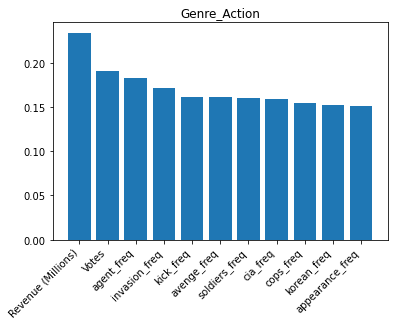

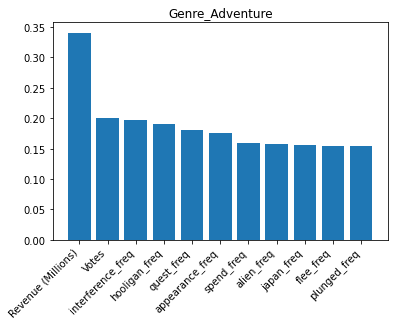

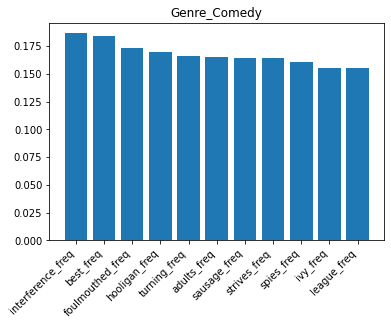

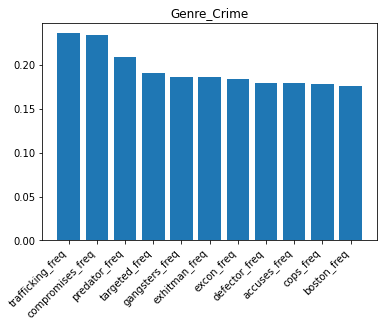

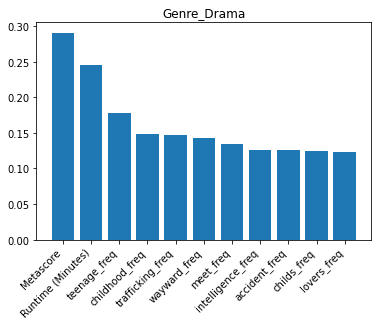

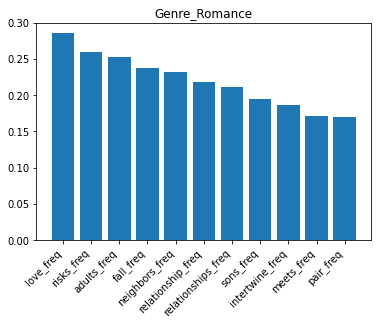

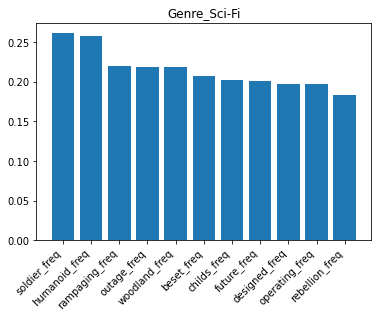

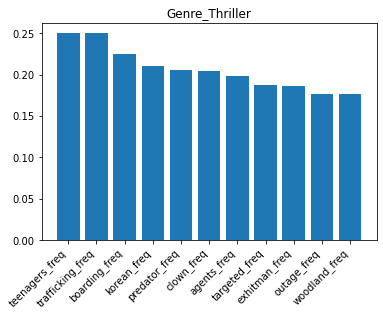

In [ ]:
# Creating basic visualizations
for genre in genre_importance:
  names = list(genre_importance[genre].keys())[:11]
  values = list(genre_importance[genre].values())[:11]
  plt.show()
  plt.bar(range(len(names)), values, tick_label=names)
  plt.xticks(rotation=45, ha='right')
  plt.title("Logistic Regression" + str(genre))

##Random Forest

In [ ]:
# Find the optimal number of trees
possible_trees = list(range(80,90,100,110,120,130,140,150,160,170,180,190))
tree_scores = []
# For each tree unmber in our selection, we're looking at the cross validation score, and picking the best one
for tree in possible_trees:
    print(tree)
    rf = MultiOutputClassifier(RandomForestClassifier(n_estimators = tree))
    tree_score = cross_val_score(rf, X_train, y_train).mean()
    tree_scores.append(tree_score)
opt_trees = possible_trees[np.argmax(tree_scores)]
print('Optimal Number of Trees:', opt_trees)

80
90
100
110
120
130
140
150
160
170
180
190
Optimal Number of Trees: 170


In [ ]:
tree_scores

[0.7071768955231705,
 0.8752281106465366,
 0.8920692580061079,
 0.8895551257253385,
 0.8899419729206963,
 0.8897485493230175,
 0.8912959381044487,
 0.8905222437137331,
 0.8901353965183751]

In [ ]:
# Import needed libraries
from sklearn.ensemble import RandomForestClassifier

# Create the random forest classifier
moc_rf = MultiOutputClassifier(RandomForestClassifier(n_estimators = 170))

In [ ]:
# Train the classifier
moc_rf = moc_rf.fit(X_train, y_train)

In [ ]:
moc_rf.score(X_test, y_test)

0.10119047619047619

In [ ]:
rf_pred = moc_rf.predict(X_test)

In [ ]:
print('ROC AUC score:', roc_auc_score(y_test, rf_pred, average='weighted'))

ROC AUC score: 0.6260626127380361


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf_pred, target_names=kept_genres))

                 precision    recall  f1-score   support

   Genre_Action       0.78      0.33      0.46        55
Genre_Adventure       0.79      0.31      0.44        49
   Genre_Comedy       0.80      0.08      0.15        48
    Genre_Crime       1.00      0.19      0.32        26
    Genre_Drama       0.86      0.66      0.75        83
  Genre_Romance       1.00      0.14      0.24        22
   Genre_Sci-Fi       0.00      0.00      0.00        26
 Genre_Thriller       0.00      0.00      0.00        35

      micro avg       0.84      0.29      0.43       344
      macro avg       0.65      0.21      0.30       344
   weighted avg       0.70      0.29      0.38       344
    samples avg       0.51      0.29      0.36       344



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Feature importances 
feat_list = []
# Analyze each model in the moc
for model in moc_rf.estimators_:
  feat_dict = {}
  # Assign each coef value to the column it corresponds to 
  for i in range(len(X.columns)):
    feat_dict[list(X.columns)[i]] = model.feature_importances_[i]
  feat_list.append(feat_dict)

In [ ]:
new_list = []
# Sort the dictionaries
for dic in feat_list:
  dic = {k: v for k, v in sorted(dic.items(), key=lambda item: -item[1])}
  new_list.append(dic)

In [ ]:
# Assigning each genre to its feature importance dictionary
genre_importance = {}
for i in range(len(list(y.columns))):
  genre = list(y.columns)[i]
  genre_importance[genre] = new_list[i]

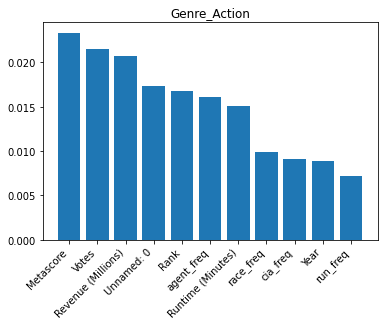

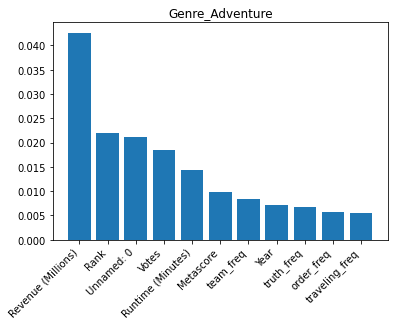

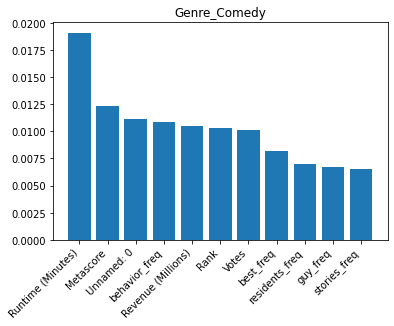

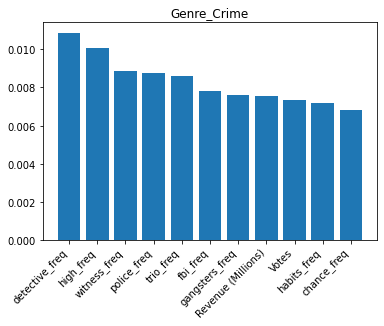

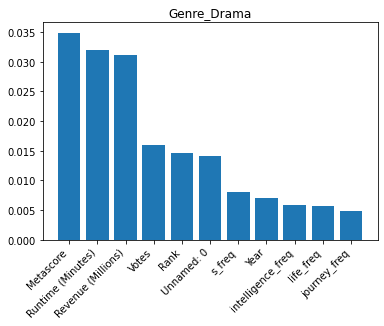

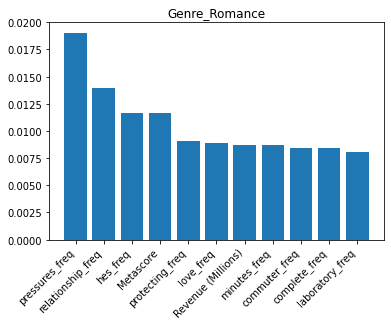

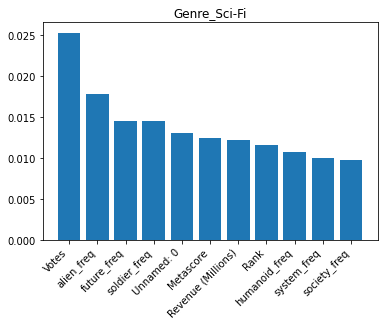

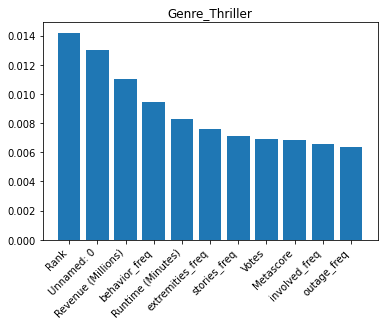

In [ ]:
# Creating basic visualizations to help us see feature importances per genre
for genre in genre_importance:
  names = list(genre_importance[genre].keys())[:11]
  values = list(genre_importance[genre].values())[:11]
  plt.show()
  plt.bar(range(len(names)), values, tick_label=names)
  plt.xticks(rotation=45, ha='right')
  plt.title(str(genre))

# Naive Bayes

In [ ]:
# Import needed libraries
from sklearn.naive_bayes import GaussianNB, BernoulliNB

In [ ]:
# Find the optimal smoothing
possible_s = [1e-27, 1e-18, 1e-9, 1e-2, 1e-1, 1, 10]
s_scores = []
for s in possible_s:
    gnb = MultiOutputClassifier(estimator=GaussianNB(var_smoothing=s))
    s_score = cross_val_score(gnb, X_train, y_train).mean()
    s_scores.append(s_score)
opt_s = possible_s[np.argmax(s_scores)]
print('Optimal smoothing:', opt_s)

In [ ]:
# Fit a Naive Bayes model that implements a combination of Gaussian and Bernoulli
class CombinedNB:
    
    '''
    Initialize both models.
    '''
    def __init__(self, var_smoothing=1, alpha=1):
        self.gnb = MultiOutputClassifier(estimator=GaussianNB(var_smoothing=var_smoothing))
        self.bnb = MultiOutputClassifier(estimator=BernoulliNB(alpha=alpha))
      
    '''
    Fit both models to the training data.
    '''
    def fit(self, X, y):
        X_gnb = X.drop(columns=[col for col in X.columns if ('Actor' in col or 'Director' in col or '_freq' in col)])
        X_bnb = X[[col for col in X.columns if ('Actor' in col or 'Director' in col or '_freq' in col)]]
        
        self.gnb.fit(X_gnb, y)
        self.bnb.fit(X_bnb, y)

    '''
    Predict labels for the data by ANDing the outputs of both classifiers together.
    '''   
    def predict(self, X):
        X_gnb = X.drop(columns=[col for col in X.columns if ('Actor' in col or 'Director' in col or '_freq' in col)])
        X_bnb = X[[col for col in X.columns if ('Actor' in col or 'Director' in col or '_freq' in col)]]
        
        return np.logical_or(np.array(self.gnb.predict(X_gnb)), np.array(self.bnb.predict(X_bnb)))
    
    '''
    Output the feature log probabilities (only for Bernoulli).
    '''
    def feature_log_prob(self):
        for i, estimator in enumerate(self.bnb.estimators_):
            in_genre_probs = estimator.feature_log_prob_[1, :].argsort()[::-1]

            print(kept_genres[i])
            print(np.take(estimator.feature_names_in_, in_genre_probs[:10]))

nb = CombinedNB(var_smoothing=opt_s)
nb.fit(X_train, y_train)

# Get most predictive features
nb.feature_log_prob()

Genre_Action
['new_freq' 'agent_freq' 'life_freq' 'girl_freq' 'world_freq' 'young_freq'
 'run_freq' 'york_freq' 'forced_freq' 'war_freq']
Genre_Adventure
['world_freq' 'team_freq' 'find_freq' 'new_freq' 'finds_freq' 'order_freq'
 'alive_freq' 'Director_Ridley Scott' 'discovers_freq' 'dangerous_freq']
Genre_Comedy
['new_freq' 'life_freq' 'girl_freq' 'hes_freq' 'family_freq'
 'perfect_freq' 'friends_freq' 'residents_freq' 'program_freq'
 'behavior_freq']
Genre_Crime
['police_freq' 'finds_freq' 'cop_freq' 'high_freq' 'family_freq'
 'witness_freq' 'school_freq' 'father_freq' 'officer_freq' 'old_freq']
Genre_Drama
['life_freq' 'new_freq' 'young_freq' 'home_freq' 'find_freq' 'girl_freq'
 'people_freq' 'Director_Ridley Scott' 'team_freq' 'world_freq']
Genre_Romance
['hes_freq' 'body_freq' 'woman_freq' 'pressures_freq' 'perfect_freq'
 'find_freq' 'mission_freq' 'sisters_freq' 'place_freq' 'war_freq']
Genre_Sci-Fi
['mission_freq' 'find_freq' 'discovers_freq' 'future_freq' 'soldier_freq'
 'team_

In [ ]:
# Measure performance of Naive Bayes model
print('ROC AUC score:', roc_auc_score(y_test, nb.predict(X_test), average='weighted'))
print('Average precision score:', average_precision_score(y_test, nb.predict(X_test), average='weighted'))
print(classification_report(y_test, nb.predict(X_test), target_names=kept_genres))

ROC AUC score: 0.6506186769258097
Average precision score: 0.39162897818992987
                 precision    recall  f1-score   support

   Genre_Action       0.47      0.87      0.61        55
Genre_Adventure       0.37      0.86      0.52        49
   Genre_Comedy       0.45      0.85      0.59        48
    Genre_Crime       0.21      0.69      0.32        26
    Genre_Drama       0.60      0.95      0.73        83
  Genre_Romance       0.27      0.73      0.40        22
   Genre_Sci-Fi       0.24      0.65      0.35        26
 Genre_Thriller       0.20      0.40      0.27        35

      micro avg       0.38      0.80      0.51       344
      macro avg       0.35      0.75      0.47       344
   weighted avg       0.41      0.80      0.53       344
    samples avg       0.41      0.80      0.51       344



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
# Find the optimal regularization parameter
possible_c = [0.01, 0.1, 1, 5, 10]
c_scores = []
for c in possible_c:
    svc_lin = MultiOutputClassifier(estimator=SVC(C=c))
    c_score = cross_val_score(svc_lin, X_train, y_train).mean()
    c_scores.append(c_score)
    print(str(c) + str(c_score))
opt_c = possible_c[np.argmax(c_scores)]
print('Optimal smoothing:', opt_c)

In [ ]:
# Fit a linear SVC model
opt_c = 0.01 # Ran this on my own machine
svc_lin = MultiOutputClassifier(estimator=SVC(C=opt_c, kernel='linear'))
svc_lin.fit(X_train, y_train)

MultiOutputClassifier(estimator=SVC(C=0.01, kernel='linear'))

In [ ]:
for i, estimator in enumerate(svc_lin.estimators_):
  print(kept_genres[i])
  in_genre_coefs = estimator.coef_[0]
  zipped_vals = list(zip(in_genre_coefs,estimator.feature_names_in_))
  zipped_vals.sort(reverse=True)
  print([x[1] for x in zipped_vals[:10]])

# Measure performance of SVC model
print('Strict accuracy:', svc_lin.score(X_test, y_test))
print('ROC AUC score:', roc_auc_score(y_test, svc_lin.predict(X_test), average='weighted'))
print('Average precision score:', average_precision_score(y_test, svc_lin.predict(X_test), average='weighted'))
print(classification_report(y_test, svc_lin.predict(X_test), target_names=kept_genres))

Genre_Action
['Revenue (Millions)', 'Votes', 'cops_freq', 'agent_freq', 'fanatical_freq', 'earth_freq', 'intergalactic_freq', 'criminals_freq', 'Director_Phil Lord', 'shaw_freq']
Genre_Adventure
['Revenue (Millions)', 'Votes', 'fanatical_freq', 'intergalactic_freq', 'Director_Louis Leterrier', 'world_freq', 'temper_freq', 'stop_freq', 'mankind_freq', 'adventure_freq']
Genre_Comedy
['Director_Christian Ditter', 'adults_freq', 'Director_Greg Mottola', 'relationships_freq', 'best_freq', 'studios_freq', 'fixer_freq', 'navigate_freq', 'Actor_Steve Zahn', 'underachieving_freq']
Genre_Crime
['trafficking_freq', 'cops_freq', 'Director_David Schwimmer', 'Actor_Liana Liberato', 'drug_freq', 'gangsters_freq', 'lawyer_freq', 'Director_John Hillcoat', 'involved_freq', 'boston_freq']
Genre_Drama
['Metascore', 'Director_Anne Fontaine', 'Rating', 'trafficking_freq', 'Runtime (Minutes)', 'Director_John Hillcoat', 'teenage_freq', 'hermione_freq', 'Director_Ridley Scott', 'meet_freq']
Genre_Romance
['Dir

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
# 3 layers chosen to allow for arbitrarily-complex model for so many features
# 500 chosen per layer as it's a large number considering the high quantity of features
# yet still remaining significantly smaller than the input layer's number of nodes

In [ ]:
# Fit a Neural Network model (3-layer 500 determined after 5-fold cross-validation test of 5 different layer/node count combinations)
neur_net = MultiOutputClassifier(estimator=MLPClassifier(hidden_layer_sizes=(500,500,500), learning_rate='adaptive', random_state=42))
neur_net.fit(X_train, y_train)

MultiOutputClassifier(estimator=MLPClassifier(hidden_layer_sizes=(500, 500,
                                                                  500),
                                              learning_rate='adaptive',
                                              random_state=42))

In [ ]:
# Measure performance of Neural Network model
print('Strict accuracy:', neur_net.score(X_test, y_test))
print('ROC AUC score:', roc_auc_score(y_test, neur_net.predict(X_test), average='weighted'))
print('Average precision score:', average_precision_score(y_test, neur_net.predict(X_test), average='weighted'))
print(classification_report(y_test, neur_net.predict(X_test), target_names=kept_genres))

Strict accuracy: 0.13095238095238096
ROC AUC score: 0.6701805165060761
Average precision score: 0.4326878822645115
                 precision    recall  f1-score   support

   Genre_Action       0.61      0.80      0.69        55
Genre_Adventure       0.56      0.49      0.52        49
   Genre_Comedy       0.49      0.67      0.57        48
    Genre_Crime       0.50      0.42      0.46        26
    Genre_Drama       0.63      0.86      0.73        83
  Genre_Romance       0.36      0.23      0.28        22
   Genre_Sci-Fi       0.50      0.35      0.41        26
 Genre_Thriller       0.24      0.14      0.18        35

      micro avg       0.55      0.58      0.57       344
      macro avg       0.49      0.49      0.48       344
   weighted avg       0.52      0.58      0.54       344
    samples avg       0.58      0.60      0.54       344



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'Loss')

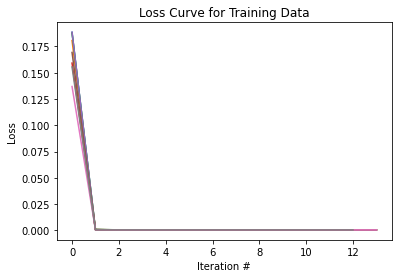

In [ ]:
# Display loss curves for each estimator to show not over/underfitting
for i in range(len(neur_net.estimators_)):
  plt.plot(neur_net.estimators_[i].loss_curve_)
  plt.title("Loss Curve for Training Data")
plt.xlabel("Iteration #")
plt.ylabel("Loss")